# Manejo de Outliers: Los Datos Rebeldes

Un **Outlier** es una observación que se encuentra a una distancia anormal de otros valores en una muestra aleatoria. No siempre son "errores"; a veces son eventos legítimos pero extremos.

### 1. ¿Cómo influyen en la creación del modelo?
Los outliers pueden "engañar" a tus algoritmos de varias formas:
* **Sesgan la Media:** La media es muy sensible a valores extremos. Un solo valor millonario en un barrio de clase media disparará el promedio, dando una imagen falsa.
* **Aumentan el Error:** Modelos como la **Regresión Lineal** intentan minimizar el cuadrado de los errores. Un outlier genera un error tan grande que el modelo "tuerce" su línea de predicción solo para intentar acercarse a ese punto, arruinando las predicciones para el resto de los datos.
* **Distorsionan el Escalado:** Si usas *StandardScaler*, un outlier comprimirá todos los demás datos en un rango minúsculo para que él pueda entrar en la escala.

---

### 2. Detección Visual: El Box-Plot (Diagrama de Caja)
El **Box-Plot** es la herramienta reina para detectar outliers visualmente. Se basa en los cuartiles y nos permite ver la dispersión en segundos.

* **La Caja:** Representa el 50% central de los datos (del Cuartil 1 al Cuartil 3).
* **La Línea Central:** Es la Mediana.
* **Los "Bigotes":** Se extienden hasta 1.5 veces el Rango Intercuartílico (IQR).
* **Puntos fuera de los bigotes:** ¡Esos son tus Outliers!



---

### 3. Técnicas de Detección Estadística
Para ser más precisos que un gráfico, usamos reglas matemáticas:

#### A. Rango Intercuartílico (IQR)
Es el método más común:
1.  Calculas $IQR = Q3 - Q1$.
2.  Límite Inferior = $Q1 - 1.5 \times IQR$.
3.  Límite Superior = $Q3 + 1.5 \times IQR$.
*Todo lo que esté fuera de estos límites se etiqueta como outlier.*

#### B. Z-Score (Puntuación Z)
Si tus datos son normales (pasaron el test de Shapiro-Wilk), puedes usar el Z-Score. Mide a cuántas desviaciones estándar está un dato de la media.
* **Regla:** Un valor con $|Z| > 3$ suele considerarse un outlier.



---

### 4. ¿Cómo tratarlos? (Estrategias)

No siempre debes borrarlos. Aquí las opciones:

| Técnica | Acción | Cuándo usarla |
| :--- | :--- | :--- |
| **Eliminación (Trimming)** | Borrar las filas con outliers. | Cuando son errores de entrada de datos o ruido evidente. |
| **Winsorización (Capping)** | "Recortar" el valor. Si el límite es 100 y el dato es 150, lo conviertes en 100. | Cuando quieres mantener el registro pero limitar la influencia del extremo. |
| **Transformación** | Aplicar $log(x)$ o raíz cuadrada. | Cuando el outlier es parte de una distribución sesgada (Skewness alto). |
| **Imputación** | Reemplazar por la Mediana. | Cuando el outlier es claramente un error de medición. |
| **Modelos Robustos** | Usar algoritmos que ignoran outliers (ej. Random Forest). | Cuando los outliers son valiosos y no quieres alterar los datos originales. |

---

### 5. Conclusión para tu flujo de trabajo
Antes de eliminar, pregunta: **"¿Este dato es un error o es un caso real extremo?"**. 
* Si es un error de sensor: **Bórralo o impútalo**.
* Si es un cliente que compra muchísimo (fraude o ballena): **Manténlo**, pero usa una técnica de escalado robusta o Winsorización para que no rompa tu modelo.

# Implementación: Detección de Outliers con IQR y Box-Plots

A continuación, utilizaremos la técnica del **Rango Intercuartílico (IQR)**. Esta técnica es preferible al Z-Score cuando nuestros datos no siguen una distribución normal perfecta, ya que la mediana y los cuartiles son mucho más robustos frente a los valores extremos.

### Código para detección y visualización

In [5]:
import pandas as pd
import numpy as np

# Seteamos una semilla para que los resultados sean siempre los mismos
np.random.seed(42)

# 1. Creamos datos para 1000 empleados
n = 1000

data = {
    # Una variable con distribución normal perfecta
    'Edad': np.random.normal(loc=35, scale=10, size=n).astype(int),
    
    # Una variable con sesgo positivo (salarios)
    'Salario_USD': np.random.exponential(scale=3000, size=n) + 1000,
    
    # Una variable con errores de captura (outliers extremos)
    'Horas_Trabajadas': np.random.normal(loc=40, scale=5, size=n)
}

df = pd.DataFrame(data)

# 2. Insertamos Outliers "Artificiales" (errores o casos extremos)
# Un empleado de 120 años (error humano)
df.loc[0, 'Edad'] = 120 

# Un salario de 50,000 USD (una "ballena" o CEO)
df.loc[1, 'Salario_USD'] = 50000 

# Horas trabajadas imposibles (error de sistema)
df.loc[2, 'Horas_Trabajadas'] = 500
df.loc[3, 'Horas_Trabajadas'] = -50

print("DataFrame creado con éxito.")
print(df.head())

DataFrame creado con éxito.
   Edad   Salario_USD  Horas_Trabajadas
0   120   1549.903405         38.453955
1    33  50000.000000         36.239218
2    41   4035.352344        500.000000
3    50   4677.384819        -50.000000
4    32   1096.287240         30.624138


--- Análisis de Outliers: Edad ---
Límite Inferior: 8.50
Límite Superior: 60.50
Total de Outliers detectados: 9
Porcentaje de Outliers: 0.90%


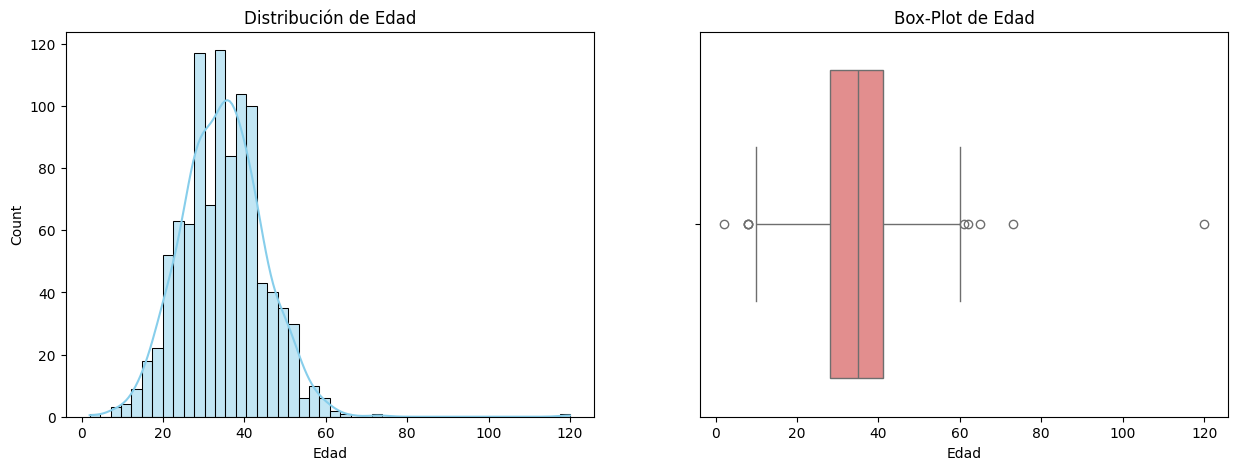

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def detectar_outliers_iqr(df, columna):
    # 1. Cálculo de Cuartiles e IQR
    q1 = df[columna].quantile(0.25)
    q3 = df[columna].quantile(0.75)
    iqr = q3 - q1
    
    # 2. Definición de Límites (Vallas)
    limite_inferior = q1 - 1.5 * iqr
    limite_superior = q3 + 1.5 * iqr
    
    # 3. Identificación
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    
    print(f"--- Análisis de Outliers: {columna} ---")
    print(f"Límite Inferior: {limite_inferior:.2f}")
    print(f"Límite Superior: {limite_superior:.2f}")
    print(f"Total de Outliers detectados: {len(outliers)}")
    print(f"Porcentaje de Outliers: {(len(outliers) / len(df)) * 100:.2f}%")
    
    # 4. Visualización Dual (Histograma + Box-Plot)
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histograma para ver la distribución y las colas
    sns.histplot(df[columna], kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title(f'Distribución de {columna}')
    
    # Box-Plot para ver los puntos fuera de los bigotes
    sns.boxplot(x=df[columna], ax=axes[1], color='lightcoral')
    axes[1].set_title(f'Box-Plot de {columna}')
    
    plt.show()
    
    return outliers

# Uso:
df_outliers = detectar_outliers_iqr(df, 'Edad')

### ¿Qué estamos viendo en este DataFrame?

Este dataset es perfecto para practicar lo que hemos aprendido:

1.  **Columna 'Edad'**: Debería seguir una distribución normal. El valor `120` será detectado como un outlier por el **Z-Score** o el **IQR**.
2.  **Columna 'Salario_USD'**: Notarás un **Skewness positivo** alto. Aquí es donde el **Box-Plot** mostrará una cola larga de puntos hacia la derecha.
3.  **Columna 'Horas_Trabajadas'**: Contiene valores físicamente imposibles (500 horas o -50 horas). Estos son el tipo de outliers que, en un **Estudio de Ablación**, verías que arruinan el rendimiento de tu modelo si no se eliminan.

---

### Ejercicio para tu Notebook:
Ahora que tienes el `df` y la función `detectar_outliers_iqr` (de la respuesta anterior), intenta ejecutar lo siguiente:


--- Análisis de Outliers: Salario_USD ---
Límite Inferior: -3066.07
Límite Superior: 10060.60
Total de Outliers detectados: 55
Porcentaje de Outliers: 5.50%


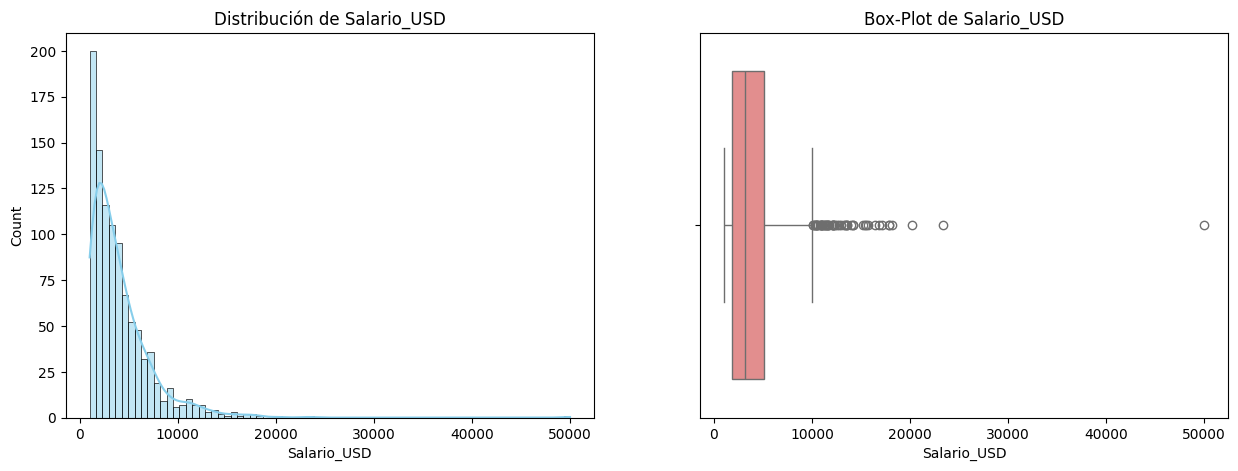

--- Análisis de Outliers: Horas_Trabajadas ---
Límite Inferior: 26.92
Límite Superior: 53.17
Total de Outliers detectados: 11
Porcentaje de Outliers: 1.10%


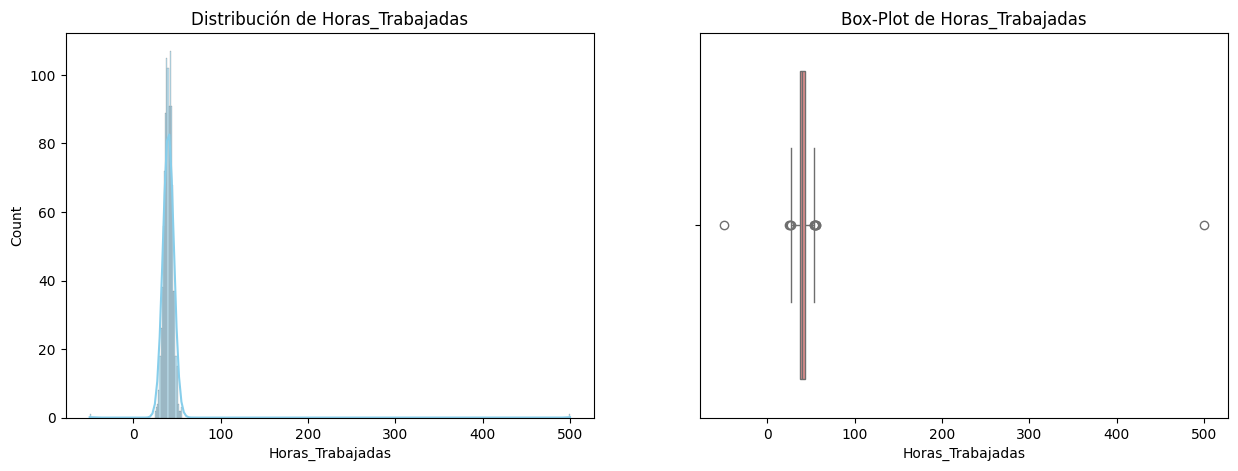

In [9]:
# Analiza la columna de Salarios
outliers_salario = detectar_outliers_iqr(df, 'Salario_USD')

# Analiza las horas trabajadas
outliers_horas = detectar_outliers_iqr(df, 'Horas_Trabajadas')